## 0. Dependency Installation ##

In [ ]:
# !pip3 install matplotlib seaborn pandas pyarrow
# !pip3 install requests
# !pip3 install rdkit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import requests, io
import re
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, DataStructs, rdFingerprintGenerator
from rdkit import RDLogger


## 1. Data Loading ##

In [3]:
# GitHub raw file link
data_url = "https://github.com/ChemBioHTP/EnzyExtract/raw/main/data/export/TheData_kcat.parquet"

# Fetch the file into memory without saving to disk
resp = requests.get(data_url)
resp.raise_for_status()  # raise error if download fails

# Read parquet from bytes using pyarrow
table = pq.read_table(io.BytesIO(resp.content))
enzy_data = table.to_pandas()

# Display basic information about the dataset
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [4]:
# Display basic information about the dataset
print("Number of rows:", len(enzy_data))
print("Number of columns:", len(enzy_data.columns))

print("Column names:")
print(enzy_data.columns)

print("First 5 rows of the dataset:")
print(enzy_data.head(5))

print("Dataset info:")
print(enzy_data.info())

Number of rows: 242115
Number of columns: 35
Column names:
Index(['enzyme', 'enzyme_full', 'substrate', 'substrate_full', 'mutant',
       'organism', 'kcat', 'km', 'kcat_km', 'temperature', 'pH', 'solution',
       'cofactors', 'other', 'descriptor', 'pmid', 'canonical', 'clean_mutant',
       'cid', 'brenda_id', 'smiles', 'cid_full', 'brenda_id_full',
       'enzyme_ecs', 'enzyme_ecs_full', 'kcat_value', 'km_value', 'sequence',
       'sequence_source', 'uniprot', 'ncbi', 'pdb', 'max_enzyme_similarity',
       'max_organism_similarity', 'total_similarity'],
      dtype='object')
First 5 rows of the dataset:
    enzyme                                        enzyme_full substrate  \
0  GPI-PLC  glycosylphosphatidylinositol-specific phosphol...       VSG   
1  GPI-PLC  glycosylphosphatidylinositol-specific phosphol...       VSG   
2  GPI-PLC  glycosylphosphatidylinositol-specific phosphol...       VSG   
3  GPI-PLC  glycosylphosphatidylinositol-specific phosphol...       VSG   
4   xSMU

## 2. EDA ##
### 2.1 Cleaning ###

In [5]:
# Drop duplicated columns
# 1. km_values is a parsed float version of km, so we drop km and only keep km_values
# 2. kcat_values is a parsed float version of kcat, so we drop kcat and only keep kcat_values
enzy_data = enzy_data.drop(columns=[c for c in ["kcat", "km"] if c in enzy_data.columns])

# Drop rows with undefined kcat or km values (we must need both for model training and validation)
enzy_data = enzy_data.dropna(subset=["kcat_value", "km_value"])

# Confirm result
print(f"New dataset shape: {enzy_data.shape}")
print(enzy_data[["kcat_value", "km_value"]].describe())

New dataset shape: (178911, 33)
         kcat_value      km_value
count  1.789110e+05  1.789110e+05
mean   1.117895e+23  2.493452e+04
std    3.343453e+25  3.951341e+06
min    0.000000e+00  0.000000e+00
25%    1.950000e-01  1.310000e-05
50%    2.800000e+00  1.300000e-04
75%    3.190000e+01  1.000000e-03
max    1.000000e+28  1.100000e+09


Explore the dataset to drop columns with missing rate above a reasonable threshold.

Sorted missing ratio per column (top 10 with most missing values):
other               1.000000
solution            1.000000
ncbi                0.985132
cofactors           0.959276
enzyme_ecs_full     0.767192
pdb                 0.737238
brenda_id_full      0.730916
cid_full            0.719816
total_similarity    0.677186
substrate_full      0.584397
dtype: float64


Total columns with 1+ missing values: 33
Max missing ratio: 1.0
Min missing ratio: 0.0


Columns with missing ratio >0%: 28
Columns with missing ratio >25%: 24
Columns with missing ratio >50%: 13
Columns with missing ratio >75%: 5




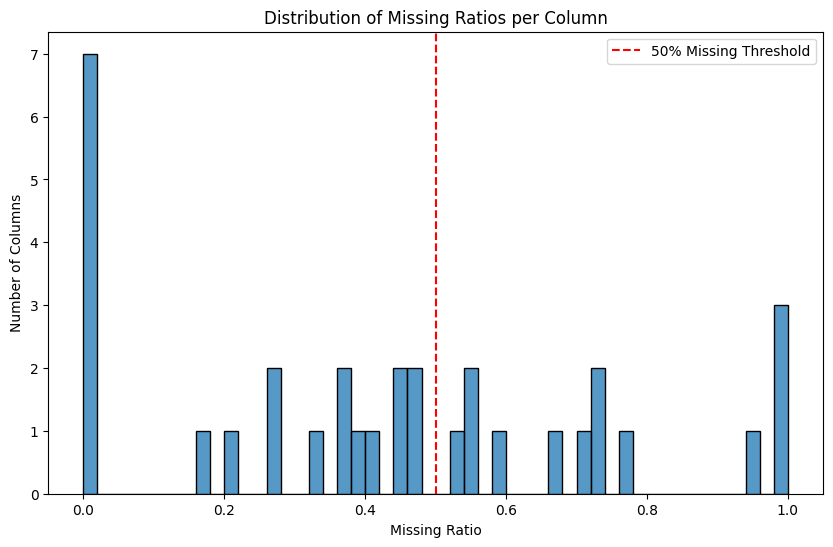

In [6]:
# First check the missing rate (proportion of NaN values).
# If a column has a missing rate > 50%, drop it (don’t include it in later analysis).
missing_ratio = enzy_data.isnull().sum() / len(enzy_data)
print("Sorted missing ratio per column (top 10 with most missing values):")
print(missing_ratio.sort_values(ascending=False).head(10))
print("\n")
print(f"Total columns with 1+ missing values: {len(missing_ratio)}")
print(f"Max missing ratio: {missing_ratio.max()}")
print(f"Min missing ratio: {missing_ratio.min()}")
print("\n")
print(f"Columns with missing ratio >0%: {missing_ratio[missing_ratio > 0].count()}")
print(f"Columns with missing ratio >25%: {missing_ratio[missing_ratio > 0.25].count()}")
print(f"Columns with missing ratio >50%: {missing_ratio[missing_ratio > 0.5].count()}")
print(f"Columns with missing ratio >75%: {missing_ratio[missing_ratio > 0.75].count()}")
print("\n")

# plot missing ratio distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(missing_ratio, bins=50, kde=False)
plt.title("Distribution of Missing Ratios per Column")
plt.xlabel("Missing Ratio")
plt.ylabel("Number of Columns")
plt.axvline(0.5, color='red', linestyle='--', label='50% Missing Threshold')
plt.legend()
plt.show()


Base on the plot above, we decided to make the missing threshold to be 50%,as nearly 40% of the features have missing rates over 50%, which help the data validation and effectiveness.

In [7]:
print(f"Original Dimension: {enzy_data.shape}")

# Remove columns with >50% missing values.
cols_to_drop = missing_ratio[missing_ratio > 0.5].index.tolist()

print(f"Dropping {len(cols_to_drop)} columns with >50% missing values.")
print("Columns to drop:")
print(cols_to_drop)

# Drop these columns from the dataset.
enzy_data = enzy_data.drop(columns=cols_to_drop)

# Check the new dataset dimensions (rows, columns) after dropping.
print(f"Updated Dimension: {enzy_data.shape}")
print("\n")

print("Remaining columns:")
print(enzy_data.columns)

# Check the missing rate again to confirm.
missing_ratio = enzy_data.isnull().sum() / len(enzy_data)
print(f"Max missing ratio: {missing_ratio.max()}")
print(f"Min missing ratio: {missing_ratio.min()}")

Original Dimension: (178911, 33)
Dropping 13 columns with >50% missing values.
Columns to drop:
['substrate_full', 'mutant', 'solution', 'cofactors', 'other', 'clean_mutant', 'cid_full', 'brenda_id_full', 'enzyme_ecs', 'enzyme_ecs_full', 'ncbi', 'pdb', 'total_similarity']
Updated Dimension: (178911, 20)


Remaining columns:
Index(['enzyme', 'enzyme_full', 'substrate', 'organism', 'kcat_km',
       'temperature', 'pH', 'descriptor', 'pmid', 'canonical', 'cid',
       'brenda_id', 'smiles', 'kcat_value', 'km_value', 'sequence',
       'sequence_source', 'uniprot', 'max_enzyme_similarity',
       'max_organism_similarity'],
      dtype='object')
Max missing ratio: 0.4768683870751379
Min missing ratio: 0.0


### 2.2 Understand Data Types ###

In [8]:
# Check the data types of each column
print("Data types of each column:")
print(enzy_data.dtypes.value_counts())
print("\n")
print(enzy_data.dtypes)

Data types of each column:
object     16
float64     4
Name: count, dtype: int64


enzyme                      object
enzyme_full                 object
substrate                   object
organism                    object
kcat_km                     object
temperature                 object
pH                          object
descriptor                  object
pmid                        object
canonical                   object
cid                         object
brenda_id                   object
smiles                      object
kcat_value                 float64
km_value                   float64
sequence                    object
sequence_source             object
uniprot                     object
max_enzyme_similarity      float64
max_organism_similarity    float64
dtype: object


As shown in the output of the cell above, most columns are objects rather than numerical data. However, we can see that some numerical data are incorrectly categrized as object (e.g. `kcat = 1188 min^-1`). We will further process the dataset to eliminate such case.

First of all, we need some shared parsing functions to convert strings to float decimals.

### 2.1.1 Visualizing Kcat and Km ###

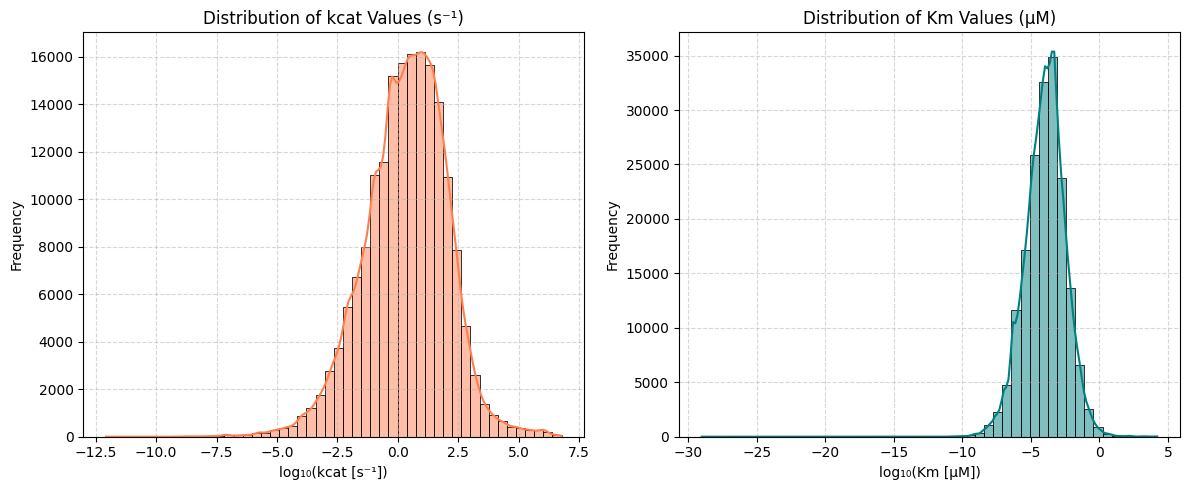

kcat_value summary (log10 scale):
count    178473.000000
mean          0.341638
std           1.715776
min         -12.071433
10%          -1.875061
50%           0.447158
90%           2.322219
max           6.773055
Name: kcat_value, dtype: float64

km_value summary (log10 scale):
count    178579.000000
mean         -3.954586
std           1.477273
min         -29.000000
10%          -5.853872
50%          -3.886057
90%          -2.167491
max           4.222716
Name: km_value, dtype: float64


In [9]:

kcat_vals = enzy_data["kcat_value"]
km_vals = enzy_data["km_value"]

# Filter out non-positive (log scale requires > 0)
kcat_vals = kcat_vals[kcat_vals > 0]
km_vals = km_vals[km_vals > 0]

# Optional: remove extreme outliers (top 0.1%)
kcat_vals = kcat_vals[kcat_vals < kcat_vals.quantile(0.999)]
km_vals = km_vals[km_vals < km_vals.quantile(0.999)]

# Log10-transform for readable distribution
log_kcat = np.log10(kcat_vals)
log_km = np.log10(km_vals)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# kcat distribution
sns.histplot(log_kcat, bins=50, kde=True, color='coral', ax=axes[0])
axes[0].set_xlabel("log₁₀(kcat [s⁻¹])")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of kcat Values (s⁻¹)")
axes[0].grid(True, ls="--", alpha=0.5)

# Km distribution
sns.histplot(log_km, bins=50, kde=True, color='teal', ax=axes[1])
axes[1].set_xlabel("log₁₀(Km [µM])")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Km Values (µM)")
axes[1].grid(True, ls="--", alpha=0.5)

plt.tight_layout()
plt.show()

# --- Summary Stats ---
print("kcat_value summary (log10 scale):")
print(log_kcat.describe(percentiles=[0.1, 0.5, 0.9]))
print("\nkm_value summary (log10 scale):")
print(log_km.describe(percentiles=[0.1, 0.5, 0.9]))

### 2.1.2 Standardizing Temperature ###

In [10]:
def _convert_token(token: str) -> float:
    """Convert single numeric token like '1.3e4' or '2x10^3' into float."""
    if token is None:
        return np.nan
    t = str(token).strip()
    if t == "":
        return np.nan

    # normalize symbols
    t = t.replace(",", "")
    t = t.replace("×", "x").replace("X", "x")
    t = re.sub(r"\s+", "", t)

    # direct float (handles e/E)
    try:
        return float(t)
    except ValueError:
        pass

    # forms like "1.2x10^4" or "1.2x10-3"
    m = re.match(r"^([\+\-]?\d*\.?\d+)\s*x\s*10\^?([\+\-]?\d+)$", t, re.IGNORECASE)
    if m:
        return float(m.group(1)) * (10 ** int(m.group(2)))

    return np.nan

def preprocess_temperature_field(text):
    """
    Cleans temperature strings before numeric parsing.
    Handles cases like:
      'pH 5.5, 30' → '30'
      'room temperature (approximately 22°c)' → '22°C'
    """
    if pd.isna(text):
        return np.nan

    t = str(text).strip().lower()

    # Remove pH parts
    t = re.sub(r"ph\s*\d+(\.\d+)?\s*,?\s*", "", t)

    # Handle 'room temperature' variants
    if "room temperature" in t or "ambient temperature" in t or re.search(r"\brt\b", t):
        # Try to extract explicit number if provided in parentheses
        match = re.search(r"(\d+(\.\d+)?)\s*°?\s*c", t)
        if match:
            t = match.group(1) + "°C"
        else:
            t = "22°C"  # default assumed room temperature
    elif "not explicitly mentioned" in t or "not mentioned" in t:
        return np.nan

    # Clean trailing punctuation
    t = t.strip(" ,;()[]")

    return t if t else np.nan

# ---------- Helper: unit detection ----------
def _detect_temperature_unit(text: str):
    """Detects temperature unit and returns (unit, factor, offset) for conversion to °C."""
    # Factor & offset to convert to °C
    # For Celsius → °C : (value * 1) + 0
    # For Kelvin  → °C : (value - 273.15)
    # For Fahrenheit → °C : (value - 32) * 5/9
    if re.search(r"[°\s]*c\b", text, re.IGNORECASE):
        return "C", 1.0, 0.0
    elif re.search(r"[°\s]*k\b", text, re.IGNORECASE):
        return "K", 1.0, -273.15
    elif re.search(r"[°\s]*f\b", text, re.IGNORECASE):
        return "F", 5/9, -32 * 5/9
    else:
        return None, None, None

def extract_numeric_segment(text):
    """
    Extract numeric portion (possibly with ± error or range) from a string that may include units.
    Returns:
      (numeric_part: str, had_unit: bool)

    Examples:
      "1.3e4 - 1.5e4 m^-1" -> ("1.3e4 - 1.5e4", True)
      "2.0x10^3/s"         -> ("2.0x10^3", True)
      "1.20 ± 0.09 s^-1"   -> ("1.20 ± 0.09", True)
      "1.20 ± 0.09"        -> ("1.20 ± 0.09", False)
    """
    if not text:
        return "", False

    t = str(text).strip()
    t = t.replace("×", "x").replace("X", "x")
    t = re.sub(r"\s+", " ", t)

    # Match numeric part: allow optional ± ... uncertainty OR range
    numeric_pattern = re.compile(
        r"""
        ^\s*
        (?P<num>
            [\d\.\+\-eExx^×\s]+              # main number or sci notation
            (?:\s*(?:±|[-–—to])\s*[\d\.\+\-eExx^×\s]+)?  # optional ± or range
        )
        (?P<unit>.*)$                        # rest of string = possible unit
        """,
        re.VERBOSE | re.IGNORECASE,
    )

    m = numeric_pattern.match(t)
    if not m:
        return t, False

    numeric_part = m.group("num").strip()
    unit_part = m.group("unit").strip()

    # Determine if there was unit text that isn't part of ± error
    # e.g. in "1.20 ± 0.09 s^-1", the "s^-1" part counts as a unit
    had_unit = bool(unit_part)

    return numeric_part, had_unit

def _convert_token(token: str):
    """
    Converts a single numeric token into a float.
    Handles scientific notation like:
      '1.3e4', '2x10^3', '2 × 10^3', etc.
    Returns np.nan if conversion fails.
    """
    if not token:
        return np.nan

    t = str(token).strip().lower()
    t = t.replace("×", "x").replace("–", "-").replace("—", "-").replace("−", "-")

    # Case 1: standard float
    try:
        return float(t)
    except ValueError:
        pass

    # Case 2: scientific notation written as "2x10^3" or "2 x 10^3"
    sci_match = re.match(r"([\+\-]?\d*\.?\d+)\s*[x×]\s*10\^?([\+\-]?\d+)", t)
    if sci_match:
        base = float(sci_match.group(1))
        exponent = float(sci_match.group(2))
        return base * (10 ** exponent)

    return np.nan

def parse_numeric_or_range(s: str):
    """
    Parse numeric or range strings:
      - '1.3e4', '1.3 × 10^4', '2x10^3'
      - '1.3e4 - 1.5e4'
      - '1.20 ± 0.09' → 1.20
    Ignores trailing units (e.g. 's^-1', 'per min').
    Returns midpoint for ranges or single value for ± notation.
    """
    if not s:
        return np.nan

    text = str(s).strip()
    if text == "":
        return np.nan

    # normalize
    t = text.replace("×", "x").replace("X", "x").replace("–", "-").replace("—", "-").replace("−", "-")
    t = re.sub(r"\s+", " ", t)
    t = re.sub(r"\bto\b", "-", t, flags=re.IGNORECASE)

    # Remove ± error parts (e.g. "1.20 ± 0.09" → "1.20")
    t = re.sub(r"\s*±\s*[\d\.eE\+\-]+", "", t)

    # Remove trailing unit strings
    t = re.sub(r"\s*(/|per|s|h|min|^-1|m|-1|µg|ug|%|fold|wt).*", "", t, flags=re.IGNORECASE).strip()

    # find up to two numeric tokens (range)
    token_pattern = r"([\+\-]?\d*\.?\d+(?:[eE][\+\-]?\d+)?|[\+\-]?\d*\.?\d+\s*[x×X]\s*10\^?[\+\-]?\d+)"
    tokens = re.findall(token_pattern, t)

    if not tokens:
        return np.nan

    if len(tokens) == 1:
        return _convert_token(tokens[0])

    # if two+ tokens, assume it's a range
    low = _convert_token(tokens[0])
    high = _convert_token(tokens[1])
    mean = (low + high) / 2.0 if np.isfinite(low) and np.isfinite(high) else np.nan
    return mean


  temperature  temperature_C
0        None            NaN
1        None            NaN
2        None            NaN
3        None            NaN
4        None            NaN
5        None            NaN
6        None            NaN
7        None            NaN
8        None            NaN
9        37°C           37.0

Temperature summary (°C):
count    139977.000000
mean         31.826434
std          19.866015
min        -271.750000
25%          25.000000
50%          30.000000
75%          37.000000
max        2361.000000
Name: temperature_C, dtype: float64

Temperature data quality counts:
valid          : 138980
unavaliable    : 38131
failed_parsing : 579
unrecognized_format: 224


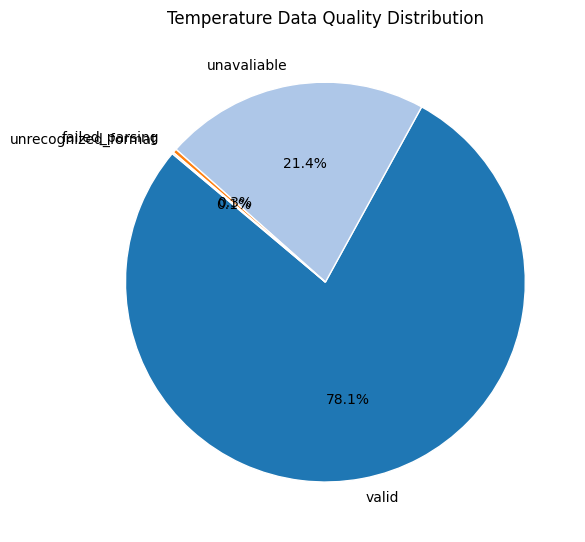

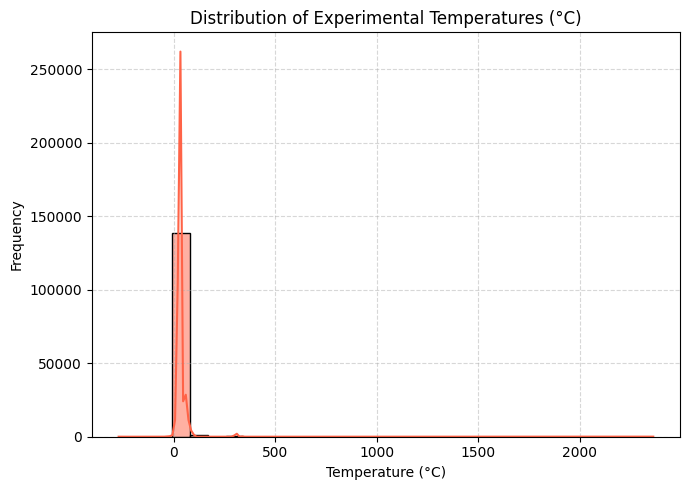

In [11]:

# ---------- Initialize counters ----------
temp_counts = {
    "valid": 0,
    "unavaliable": 0,
    "failed_parsing": 0,
    "unrecognized_format": 0,
}

# ---------- Main cleaner ----------
def clean_temperature(value):
    """
    Parse temperature strings like:
      '37 °C', '310 K', '98.6°F', '25', '20-25 °C', '30 ± 2°C'
    Returns standardized float in °C.
    """
    if pd.isna(value):
        temp_counts["unavaliable"] += 1
        return np.nan

    text = str(value).strip()
    if not text:
        temp_counts["unavaliable"] += 1
        return np.nan

    # Extract numeric portion
    numeric_seg, had_unit = extract_numeric_segment(text)
    if not numeric_seg:
        temp_counts["failed_parsing"] += 1
        # print(f"⚠️ Invalid parsing: {text}")
        return np.nan

    val = parse_numeric_or_range(numeric_seg)
    if not np.isfinite(val):
        temp_counts["failed_parsing"] += 1
        # print(f"⚠️ Invalid parsing: {text}")
        return np.nan

    # Detect unit and convert to °C
    unit, factor, offset = _detect_temperature_unit(text)
    if unit == "C":
        temp_counts["valid"] += 1
        return val
    elif unit == "K":
        temp_counts["valid"] += 1
        return val + offset
    elif unit == "F":
        temp_counts["valid"] += 1
        return val * factor + offset
    elif not had_unit:
        return val # Assume °C if no unit is provided (most biochemical data default to °C)
    else:
        temp_counts["unrecognized_format"] += 1
        # print(f"⚠️ Unrecognized unit: {text}")
        return np.nan

# ---------- Apply cleaning ----------
enzy_data["temperature_prepossed"] = enzy_data["temperature"].apply(preprocess_temperature_field)
enzy_data["temperature_C"] = enzy_data["temperature_prepossed"].apply(clean_temperature)

# ---------- Summary ----------
print(enzy_data[["temperature", "temperature_C"]].head(10))
print("\nTemperature summary (°C):")
print(enzy_data["temperature_C"].describe())
print("\nTemperature data quality counts:")
for k, v in temp_counts.items():
    print(f"{k:15s}: {v}")

# --- Pie chart ---
plt.figure(figsize=(6, 6))
labels = list(temp_counts.keys())
sizes = list(temp_counts.values())
colors = plt.cm.tab20.colors[:len(labels)]

plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    wedgeprops={"edgecolor": "white"}
)

plt.title("Temperature Data Quality Distribution")
plt.tight_layout()
plt.show()

# ---------- Distribution plot ----------
valid_temps = enzy_data["temperature_C"].dropna()
plt.figure(figsize=(7, 5))
sns.histplot(valid_temps, bins=30, kde=True, color="tomato")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.title("Distribution of Experimental Temperatures (°C)")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

// todo remove outlier temperature

### 2.1.3 Standardizing pH ###

           pH  pH_value
0        None       NaN
1        None       NaN
2        None       NaN
3        None       NaN
4        None       NaN
5        None       NaN
6        None       NaN
7        None       NaN
8        None       NaN
9  6.5 to 7.5       7.0

Summary of cleaned pH:
count    128161.000000
mean          7.549365
std           4.214580
min           0.033000
25%           7.000000
50%           7.400000
75%           7.800000
max         150.000000
Name: pH_value, dtype: float64

Quality counts:
valid          : 128005
failed_parsing : 5
unavaliable    : 49068
unrecognized_format: 1677


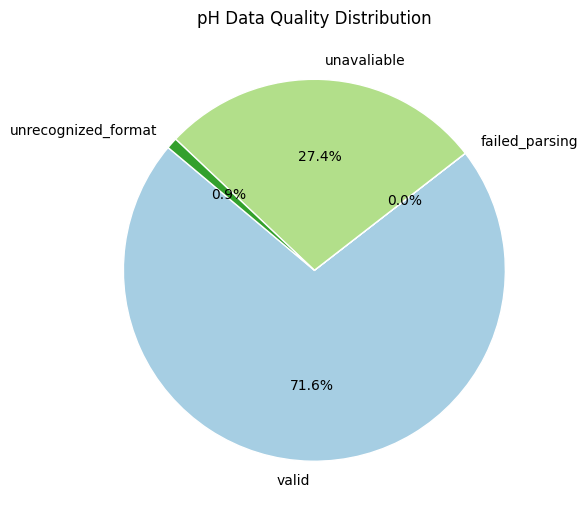

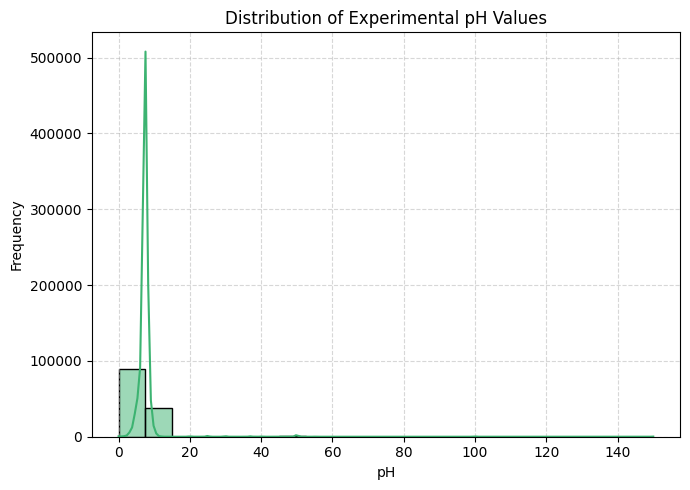

In [12]:
# -------------------------------------
# Counters for quality tracking
# -------------------------------------
ph_counts = {
    "valid": 0,
    "failed_parsing": 0,
    "unavaliable": 0,
    "unrecognized_format": 0,
}

# -------------------------------------
# Main parser
# -------------------------------------
def clean_ph(value):
    """
    Parse pH strings into numeric values.
    Handles formats like:
      'pH 7.0', '7.5', '6.5-7.0', '≈7', 'around 6', 'neutral', 'acidic', 'basic'
    Returns float pH value.
    """
    if pd.isna(value):
        ph_counts["unavaliable"] += 1
        return np.nan

    text = str(value).strip().lower()
    if not text:
        ph_counts["unavaliable"] += 1
        return np.nan

    if any(x in text for x in ["unknown", "n/a", "—", "–"]):
        ph_counts["unavaliable"] += 1
        return np.nan

    # Handle qualitative terms
    if "neutral" in text:
        # ph_counts["approx"] += 1
        return 7.0
    elif "acidic" in text:
        # ph_counts["approx"] += 1
        return 5.0
    elif "basic" in text or "alkaline" in text:
        # ph_counts["approx"] += 1
        return 9.0

    # Extract numeric or range
    # e.g. "pH 7.0", "7.5", "6.5-7.0", "7 ± 0.2"
    match_range = re.match(r"p?h?\s*([\d\.]+)\s*[-–to]+\s*([\d\.]+)", text)
    if match_range:
        try:
            low = float(match_range.group(1))
            high = float(match_range.group(2))
            ph_counts["valid"] += 1
            return (low + high) / 2.0
        except ValueError:
            ph_counts["failed_parsing"] += 1
            return np.nan

    match_single = re.match(r"p?h?\s*([\d\.]+)", text)
    if match_single:
        try:
            val = float(match_single.group(1))
            ph_counts["valid"] += 1
            return val
        except ValueError:
            ph_counts["failed_parsing"] += 1
            return np.nan

    # Could not parse
    ph_counts["unrecognized_format"] += 1
    # print(f"⚠️ Unparsed pH entry: '{text}'")
    return np.nan


# -------------------------------------
# Apply cleaning
# -------------------------------------
enzy_data["pH_value"] = enzy_data["pH"].apply(clean_ph)

# -------------------------------------
# Summary
# -------------------------------------
print(enzy_data[["pH", "pH_value"]].head(10))
print("\nSummary of cleaned pH:")
print(enzy_data["pH_value"].describe())
print("\nQuality counts:")
for k, v in ph_counts.items():
    print(f"{k:15s}: {v}")

# -------------------------------------
# Pie chart
# -------------------------------------
plt.figure(figsize=(6, 6))
labels = list(ph_counts.keys())
sizes = list(ph_counts.values())
colors = plt.cm.Paired.colors[:len(labels)]

plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    wedgeprops={"edgecolor": "white"}
)

plt.title("pH Data Quality Distribution")
plt.tight_layout()
plt.show()

# -------------------------------------
# Distribution plot
# -------------------------------------
valid_ph = enzy_data["pH_value"].dropna()
plt.figure(figsize=(7, 5))
sns.histplot(valid_ph, bins=20, kde=True, color="mediumseagreen")
plt.xlabel("pH")
plt.ylabel("Frequency")
plt.title("Distribution of Experimental pH Values")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

### 2.1.4 Check Health Status ###

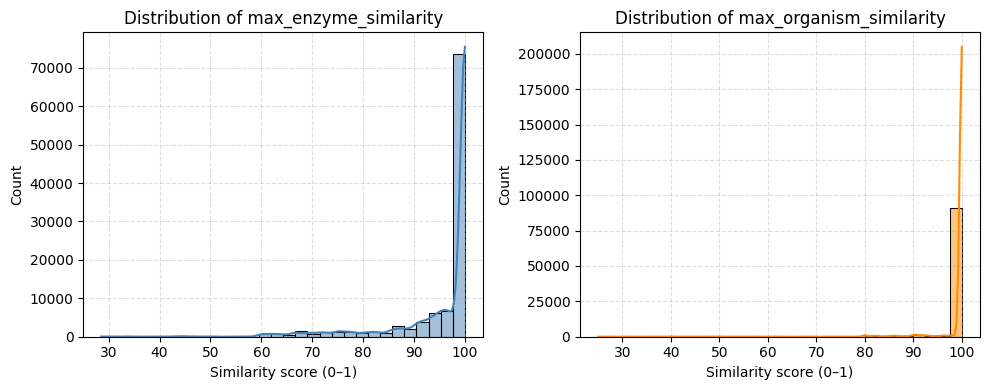

In [13]:
# Drop NaN and check valid ranges
enz_sim = enzy_data["max_enzyme_similarity"].dropna()
org_sim = enzy_data["max_organism_similarity"].dropna()


plt.figure(figsize=(10, 4))

# Plot enzyme similarity
plt.subplot(1, 2, 1)
sns.histplot(enz_sim, bins=30, kde=True, color="steelblue")
plt.title("Distribution of max_enzyme_similarity")
plt.xlabel("Similarity score (0–1)")
plt.ylabel("Count")
plt.grid(True, ls="--", alpha=0.4)

# Plot organism similarity
plt.subplot(1, 2, 2)
sns.histplot(org_sim, bins=30, kde=True, color="darkorange")
plt.title("Distribution of max_organism_similarity")
plt.xlabel("Similarity score (0–1)")
plt.ylabel("Count")
plt.grid(True, ls="--", alpha=0.4)

plt.tight_layout()
plt.show()


In [14]:
print(f"Original Dimension: {enzy_data.shape}")
original_row_count = enzy_data.shape[0]

# drop rows with similarity < 60
enzy_data = enzy_data[(enzy_data["max_enzyme_similarity"].isna()) | (enzy_data["max_enzyme_similarity"] >= 60)]
enzy_data = enzy_data[(enzy_data["max_organism_similarity"].isna()) | (enzy_data["max_organism_similarity"] >= 60)]

print(f"Updated Dimension: {enzy_data.shape}")
print(f"Dropped {original_row_count - enzy_data.shape[0]} rows with similarity < 60%")

Original Dimension: (178911, 23)
Updated Dimension: (178144, 23)
Dropped 767 rows with similarity < 60%


### 2.1.4 Cleaning Sequence ###

In [15]:

print(f"Original number of rows: {len(enzy_data)}")
# drop rows where 'sequence' is NaN or None
enzy_data_clean = enzy_data.dropna(subset=['sequence']).reset_index(drop=True)
print(f"Updated number of rows after dropping empty sequences: {len(enzy_data_clean)}")

Original number of rows: 178144
Updated number of rows after dropping empty sequences: 111006


In [16]:
# could be done later in data processing pipeline


# #对enzy_data_pro里面的sequence_source进行one-hot编码处理
# from sklearn.preprocessing import OneHotEncoder
# # 处理blanks
# enzy_data_pro['sequence_source'] = enzy_data_pro['sequence_source'].fillna('unknown')
# # 初始化 One-Hot 编码器
# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# # 拟合并转换
# sequence_encoded = encoder.fit_transform(enzy_data_pro[['sequence_source']])

# #  创建新的 One-Hot DataFrame
# sequence_ohe_cols = [f"sequence_{cat}" for cat in encoder.categories_[0]]
# sequence_ohe_df = pd.DataFrame(sequence_encoded, columns=sequence_ohe_cols, index=enzy_data_pro.index)

# # 合并回原表
# enzy_data_pro = pd.concat([enzy_data_pro, sequence_ohe_df], axis=1)

# # 检查结果
# print(enzy_data_pro.head())


In [17]:
# remove original columns that have been processed into new columns
enzy_data_pro = enzy_data_clean.copy()
enzy_data_pro = enzy_data_pro.drop(columns=["kcat", "km", "kcat_km","temperature","temperature_prepossed", "pH", "sequence_source"], errors='ignore')

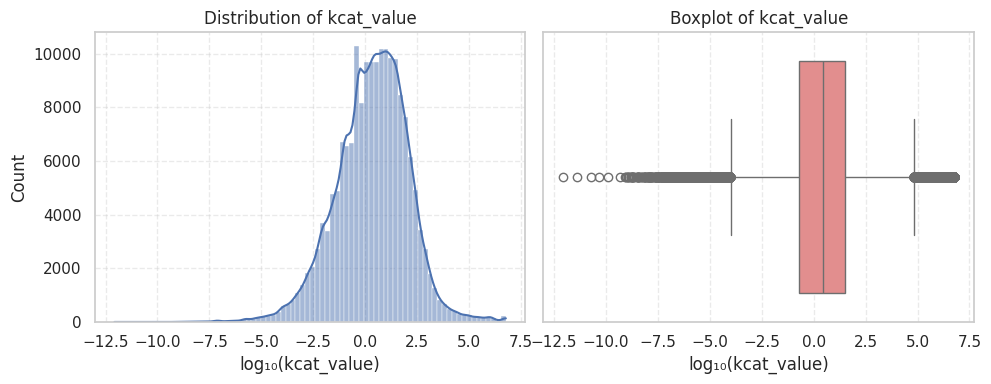

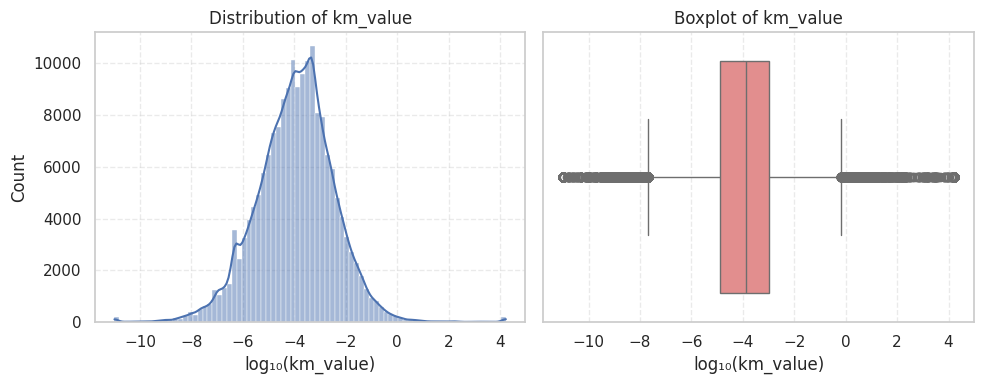

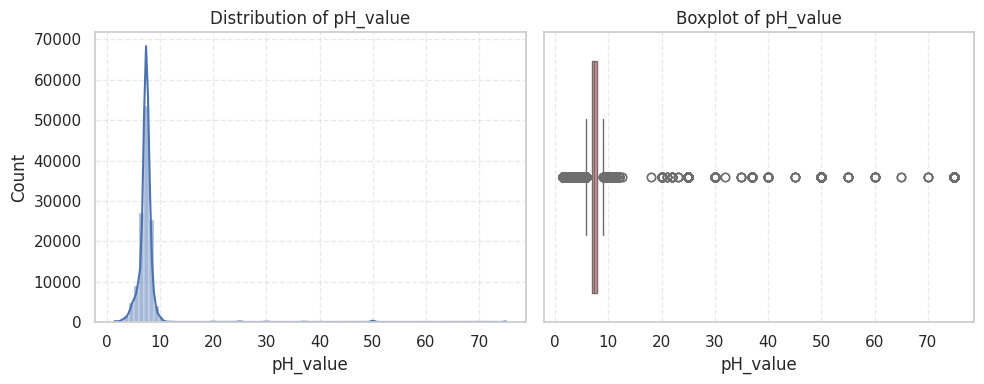

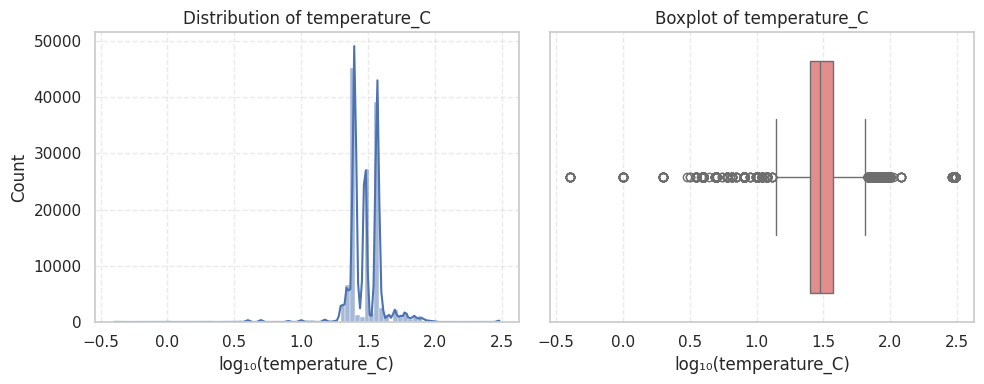

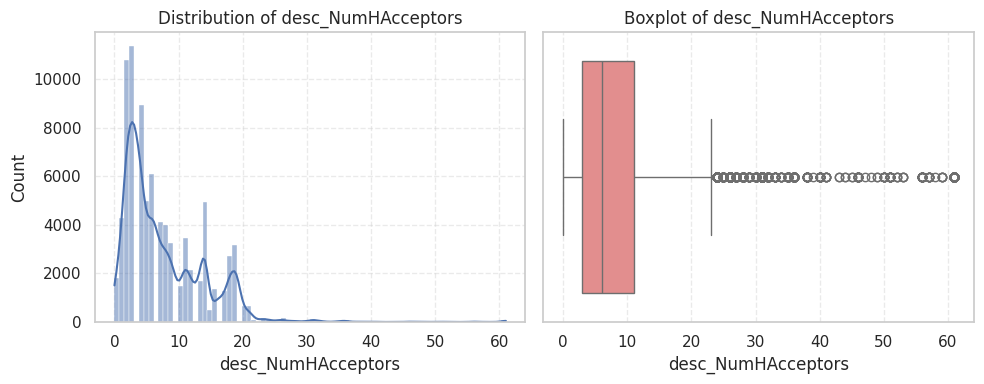

In [32]:

num_cols = ["kcat_value", "km_value", "pH_value", "temperature_C"]

# histogram (+ KDE) for distribution; boxplot for visualizing outliers
for col in num_cols:
    # 1) coerce to numeric, drop NaN/inf
    s = pd.to_numeric(enzy_data_pro[col], errors="coerce")
    s = s[np.isfinite(s)]
    if s.empty:
        print(f"[{col}] no valid data.")
        continue

    # 2) winsorize to avoid monster outliers that explode binning
    lo, hi = np.nanpercentile(s, [0.1, 99.9])
    s_clip = s.clip(lower=lo, upper=hi)

    # 3) auto log if strictly positive and very skewed (spans > 2 orders of magnitude)
    def needs_log(x: pd.Series) -> bool:
        x_pos = x[x > 0]
        if x_pos.empty:
            return False
        return (x_pos.max() / max(x_pos.min(), 1e-12)) >= 100  # ~2+ orders

    use_log = needs_log(s_clip)
    if use_log:
        s_plot = np.log10(s_clip[s_clip > 0])
        xlab = f"log₁₀({col})"
    else:
        s_plot = s_clip
        xlab = col

    # 4) reasonable number of bins
    bins = min(80, max(20, int(np.sqrt(len(s_plot)))))

    plt.figure(figsize=(10, 4))

    # left: histogram (+ KDE)
    plt.subplot(1, 2, 1)
    sns.histplot(s_plot, bins=bins, kde=True)
    plt.xlabel(xlab)
    plt.ylabel("Count")
    plt.title(f"Distribution of {col}")
    plt.grid(True, ls="--", alpha=0.4)

    # right: boxplot (same transformed scale so it matches)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=s_plot, color="lightcoral")
    plt.xlabel(xlab)
    plt.title(f"Boxplot of {col}")
    plt.grid(True, axis="x", ls="--", alpha=0.4)

    plt.tight_layout()
    plt.show()

## 2.1.5 Bivariate and Multivariate Analysis ##

In [19]:
sns.set(style="whitegrid", context="notebook")
pd.set_option('display.max_columns', 120)

In [20]:
enzy_data_pro= enzy_data_pro.drop(['max_enzyme_similarity', 'max_organism_similarity'], axis=1)


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


               x           y    method      corr        pvalue
0  temperature_C  kcat_value   pearson -0.003595  2.884062e-01
1  temperature_C  kcat_value  spearman -0.038267  1.226519e-29


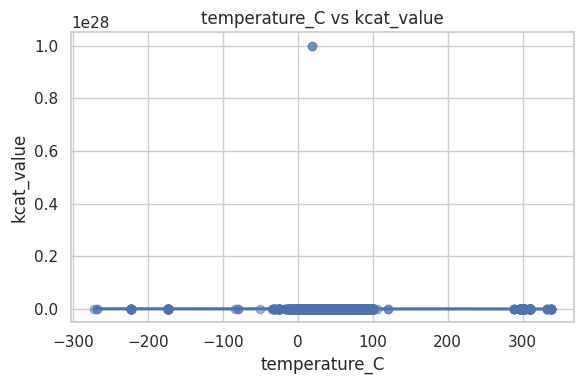

          x           y    method      corr         pvalue
0  pH_value  kcat_value   pearson -0.000758   8.302018e-01
1  pH_value  kcat_value  spearman -0.089450  8.868325e-142


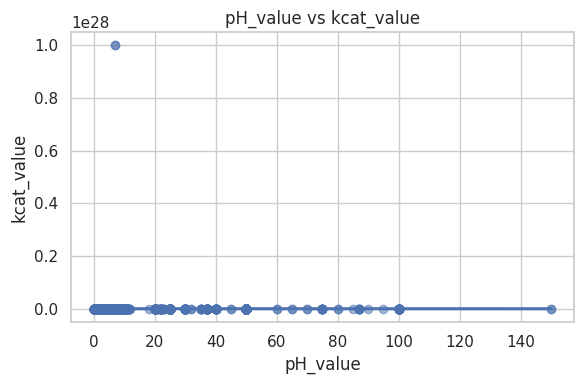

               x             y    method      corr        pvalue
0  temperature_C  kcat_over_km   pearson -0.003596  2.884824e-01
1  temperature_C  kcat_over_km  spearman -0.069103  1.042380e-92


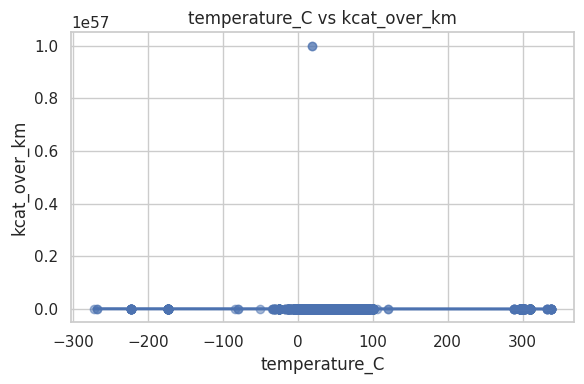

          x             y    method      corr        pvalue
0  pH_value  kcat_over_km   pearson -0.000759  8.300634e-01
1  pH_value  kcat_over_km  spearman -0.049536  1.308189e-44


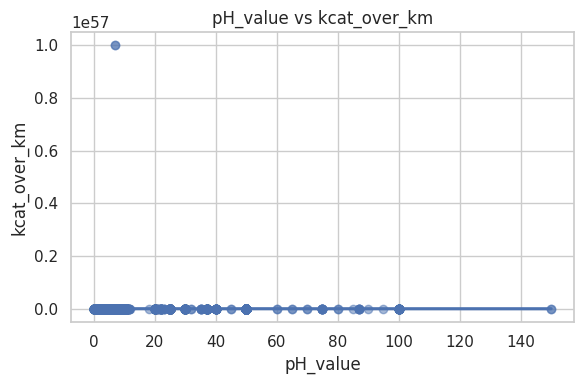

               x               y    method      corr        pvalue
0  temperature_C  log_kcat_value   pearson  0.004201  2.151105e-01
1  temperature_C  log_kcat_value  spearman -0.038313  1.161460e-29


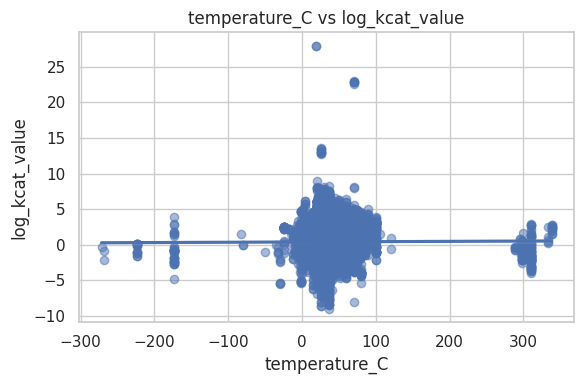

          x                 y    method      corr        pvalue
0  pH_value  log_kcat_over_km   pearson  0.002599  4.626729e-01
1  pH_value  log_kcat_over_km  spearman -0.049238  4.580289e-44


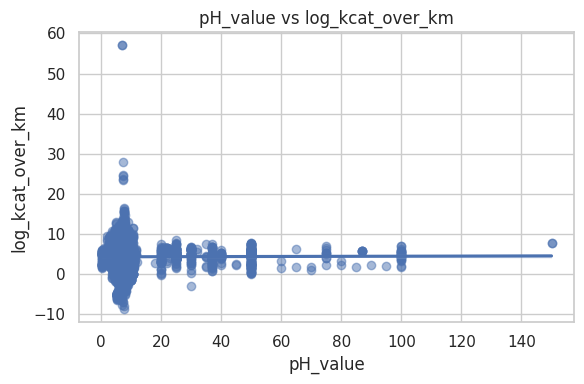

,x,y,method,corr,pvalue
4,temperature_C,kcat_over_km,pearson,-0.003596,2.884824e-01
6,pH_value,kcat_over_km,pearson,-0.000759,8.300634e-01
5,temperature_C,kcat_over_km,spearman,-0.069103,1.042380e-92
7,pH_value,kcat_over_km,spearman,-0.049536,1.308189e-44
0,temperature_C,kcat_value,pearson,-0.003595,2.884062e-01
2,pH_value,kcat_value,pearson,-0.000758,8.302018e-01
1,temperature_C,kcat_value,spearman,-0.038267,1.226519e-29
3,pH_value,kcat_value,spearman,-0.089450,8.868325e-142
10,pH_value,log_kcat_over_km,pearson,0.002599,4.626729e-01
11,pH_value,log_kcat_over_km,spearman,-0.049238,4.580289e-44


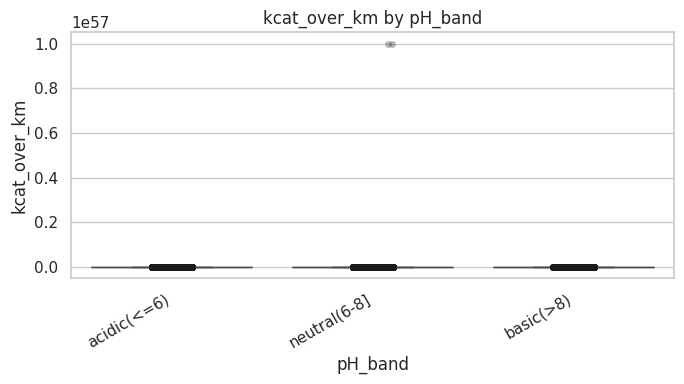

/tmp/ipython-input-2724176212.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g[num_col].values for _, g in d.groupby(cat_col)]


             test     stat    pvalue  groups  cat_col       num_col
0  Kruskal-Wallis  2.34505  0.309584       3  pH_band  kcat_over_km


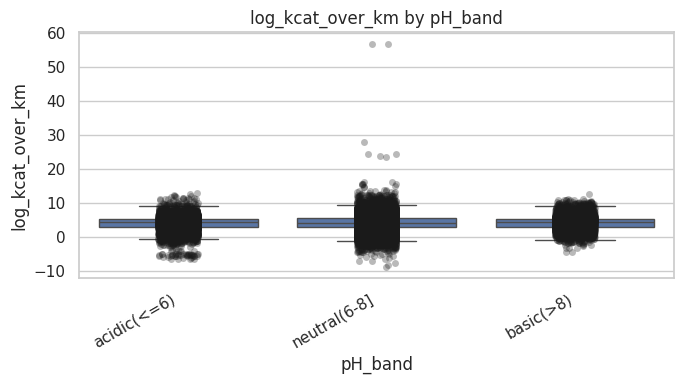

             test     stat    pvalue  groups  cat_col           num_col
0  Kruskal-Wallis  1.71455  0.424317       3  pH_band  log_kcat_over_km


/tmp/ipython-input-2724176212.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g[num_col].values for _, g in d.groupby(cat_col)]


In [21]:
# Derive variables

# numeric columns
numeric_cols = [
    'kcat_value', 'km_value', 'temperature_C', 'pH_value']
#categorical columns
cat_cols = ['enzyme', 'organism', 'substrate']

# Derived variable: catalytic efficiency (avoiding division by zero)
enzy_data_pro['kcat_over_km'] = np.where(
    (enzy_data_pro['km_value'].notna()) & (enzy_data_pro['km_value'] != 0),
    enzy_data_pro['kcat_value'] / enzy_data_pro['km_value'],
    np.nan
)

# Log transformation for skewed distributions
for col in ['kcat_value', 'km_value', 'kcat_over_km']:
    if col in enzy_data_pro.columns:
        enzy_data_pro[f'log_{col}'] = np.where(enzy_data_pro[col] > 0, np.log10(enzy_data_pro[col]), np.nan)

# pH range discretization
if 'pH_value' in enzy_data_pro.columns:
    enzy_data_pro['pH_band'] = pd.cut(
        enzy_data_pro['pH_value'],
        bins=[-np.inf, 6.0, 8.0, np.inf],
        labels=['acidic(<=6)', 'neutral(6-8]', 'basic(>8)']
    )


#Numeric vs. numeric: correlation, scatter plot + regression line

def corr_and_plot_num_num(x, y, data, method_list=['pearson','spearman']):
    d = data[[x, y]].dropna()
    if d.empty:
        print(f"[WARN] {x} vs {y} no data")
        return None

    rows = []
    for m in method_list:
        if m == 'pearson':
            r, p = stats.pearsonr(d[x], d[y])
        elif m == 'spearman':
            r, p = stats.spearmanr(d[x], d[y])
        else:
            continue
        rows.append({'x': x, 'y': y, 'method': m, 'corr': r, 'pvalue': p})
    corr_df = pd.DataFrame(rows)
    print(corr_df)

    #Scatter plot + linear regression (Gaussian fit switchable with lowess=True)
    plt.figure(figsize=(6, 4))
    sns.regplot(x=x, y=y, data=d, scatter_kws={'alpha':0.5})
    plt.title(f'{x} vs {y}')
    plt.tight_layout()
    plt.show()
    return corr_df

#main pairs
pairs_num_num = [
    ('temperature_C', 'kcat_value'),
    ('pH_value', 'kcat_value'),
    ('temperature_C', 'kcat_over_km'),
    ('pH_value', 'kcat_over_km'),
    ('temperature_C', 'log_kcat_value'),
    ('pH_value', 'log_kcat_over_km'),
]

corr_results = []
for x, y in pairs_num_num:
    if x in enzy_data_pro.columns and y in enzy_data_pro.columns:
        res = corr_and_plot_num_num(x, y, enzy_data_pro)
        if isinstance(res, pd.DataFrame):
            corr_results.append(res)

if corr_results:
    corr_summary = pd.concat(corr_results, ignore_index=True)
    display(corr_summary.sort_values(['y','method']))

# Numeric vs. categorical: group differences, boxplot/violin plot, Kruskal test

def num_vs_cat_tests(num_col, cat_col, data, min_count_per_group=5):

    d = data[[num_col, cat_col]].dropna()
    if d.empty:
        print(f"[WARN] {num_col} vs {cat_col} no data")
        return None

    # filter small groups
    counts = d[cat_col].value_counts()
    valid_groups = counts[counts >= min_count_per_group].index
    d = d[d[cat_col].isin(valid_groups)]
    if d[cat_col].nunique() < 2:
        print(f"[WARN] {cat_col} less than 2 valid group")
        return None

    # boxplot/violin plot
    plt.figure(figsize=(7, 4))
    sns.boxplot(x=cat_col, y=num_col, data=d, showfliers=False)
    sns.stripplot(x=cat_col, y=num_col, data=d, color='k', alpha=0.3)
    plt.title(f'{num_col} by {cat_col}')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

    #Kruskal-Wallis
    groups = [g[num_col].values for _, g in d.groupby(cat_col)]
    H, p_kw = stats.kruskal(*groups)


    print(pd.DataFrame({
        'test': ['Kruskal-Wallis'],
        'stat': [H],
        'pvalue': [p_kw],
        'groups': [len(groups)],
        'cat_col': [cat_col],
        'num_col': [num_col]
    }))

# num vs cat
num_cat_pairs = [
    ('kcat_over_km', 'pH_band'),
    ('kcat_over_km', 'temp_band'),
    ('log_kcat_over_km', 'pH_band'),
    ('log_kcat_over_km', 'temp_band')
]

for num_col, cat_col in num_cat_pairs:
    if num_col in enzy_data_pro.columns and cat_col in enzy_data_pro.columns:
        num_vs_cat_tests(num_col, cat_col, enzy_data_pro, min_count_per_group=8)




Pearson correlation tests show no significant linear relationship between enzyme kinetic parameters (kcat, kcat/km) and environmental variables (temperature_C, pH_value, max_enzyme_similarity, max_organism_similarity).

Spearman rank correlations indicate statistically significant but weak negative associations (|r| < 0.1) between kcat (or kcat/km) and temperature/pH, suggesting that enzyme catalytic performance slightly decreases with increasing temperature and alkalinity.

However, given the extremely small correlation magnitudes, these relationships are unlikely to be biologically meaningful. Multivariate analyses are required to uncover potential combined effects.

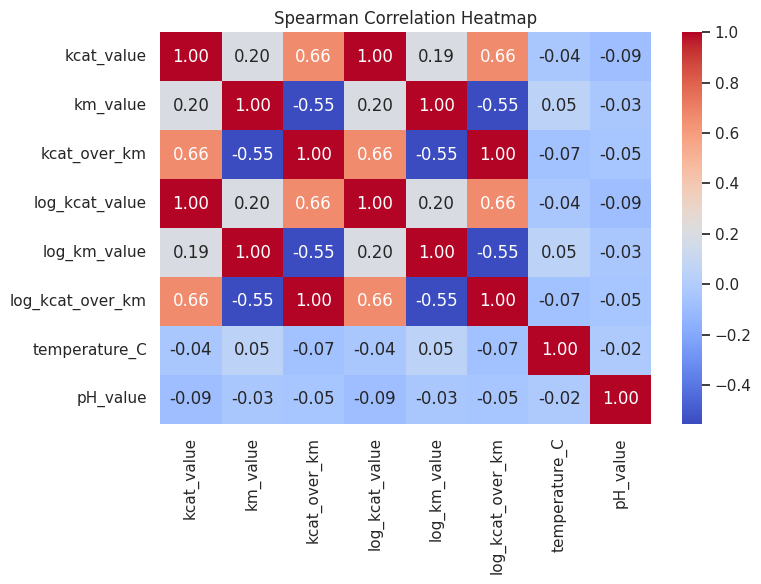

In [22]:
# pairs for heat map
corr_cols = [
    c for c in [
        'kcat_value', 'km_value', 'kcat_over_km',
        'log_kcat_value', 'log_km_value', 'log_kcat_over_km',
        'temperature_C', 'pH_value',
    ] if c in enzy_data_pro.columns
]
corr_df = enzy_data_pro[corr_cols].copy()

# Spearman Heat Map
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df.corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Spearman Correlation Heatmap')
plt.tight_layout()
plt.show()

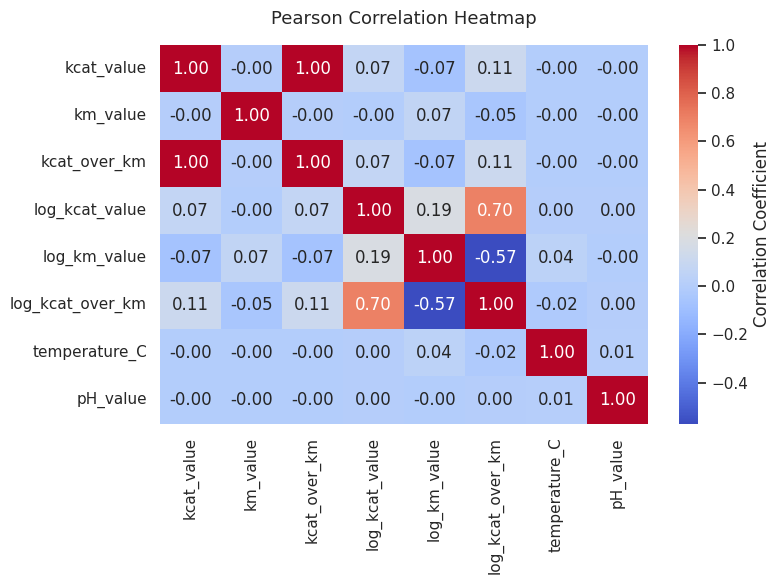

In [23]:
# pearson Heat Map
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_df.corr(method='pearson'),
    annot=True, cmap='coolwarm', fmt=".2f",
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Pearson Correlation Heatmap', fontsize=13, pad=15)
plt.tight_layout()
plt.show()

两个热力图并没有很好的反应特征之间的关联系
*在酶动力学关系中，log(kcat) vs log(Km) 或 log(kcat/Km) 可能才是有意义的协变结构
让我接下来尝试一下

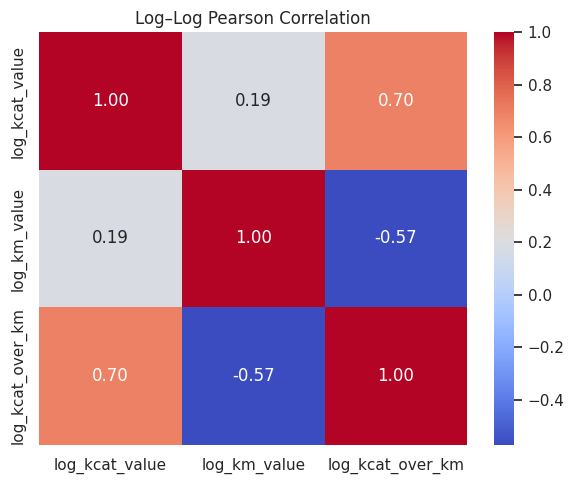

In [24]:
log_cols = ['log_kcat_value', 'log_km_value', 'log_kcat_over_km']
plt.figure(figsize=(6,5))
sns.heatmap(enzy_data_pro[log_cols].corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Log–Log Pearson Correlation")
plt.tight_layout()
plt.show()

分组相关性（分 enzyme 或 organism 层级计算）
不同酶种的活性范围和条件差异极大，所以全局相关几乎被“组间方差”淹没

In [25]:
grouped_corr = (
    enzy_data_pro.groupby("enzyme")[["log_kcat_value", "log_km_value", "log_kcat_over_km"]]
    .corr(method='pearson')
    .unstack()
)
display(grouped_corr.head(10))

log_kcat_value  \
                                                   log_kcat_value   
enzyme                                                              
(+)-germacrene D synthase                                     NaN   
(+)-limonene synthase                                         1.0   
(2S)-methylsuccinyl-CoA dehydrogenase                         1.0   
(BACCR)NAT3 E123D                                             1.0   
(BACCR)NAT3 WT                                                1.0   
(E)-β-farnesene synthase                                      NaN   
(R)-1-hydroxy-2-aminoethylphosphonate ammonia-l...            NaN   
(R)-2,4-DP/α-KG dioxygenase                                   1.0   
(R)-selective transaminase                                    1.0   
(S)-2,4-DP/α-KG dioxygenase                                   1.0   

                                                                 \
                                                   log_km_value   
enzyme                                                            
(+)-germacrene D synthase                                   NaN   
(+)-limonene synthase                                 -0.871420   
(2S)-methylsuccinyl-CoA dehydrogenase                 -0.373642   
(BACCR)NAT3 E123D                                      0.287981   
(BACCR)NAT3 WT                                              NaN   
(E)-β-farnesene synthase                                    NaN   
(R)-1-hydroxy-2-aminoethylphosphonate ammonia-l...          NaN   
(R)-2,4-DP/α-KG dioxygenase                           -0.531501   
(R)-selective transaminase                             0.181279   
(S)-2,4-DP/α-KG dioxygenase                            0.287873   

                                                                     \
                                                   log_kcat_over_km   
enzyme                                                                
(+)-germacrene D synthase                                       NaN   
(+)-limonene synthase                                      0.964775   
(2S)-methylsuccinyl-CoA dehydrogenase                      0.968137   
(BACCR)NAT3 E123D                                          0.286307   
(BACCR)NAT3 WT                                             1.000000   
(E)-β-farnesene synthase                                        NaN   
(R)-1-hydroxy-2-aminoethylphosphonate ammonia-l...              NaN   
(R)-2,4-DP/α-KG dioxygenase                                0.844918   
(R)-selective transaminase                                 0.206658   
(S)-2,4-DP/α-KG dioxygenase                                0.312678   

                                                     log_km_value  \
                                                   log_kcat_value   
enzyme                                                              
(+)-germacrene D synthase                                     NaN   
(+)-limonene synthase                                   -0.871420   
(2S)-methylsuccinyl-CoA dehydrogenase                   -0.373642   
(BACCR)NAT3 E123D                                        0.287981   
(BACCR)NAT3 WT                                                NaN   
(E)-β-farnesene synthase                                      NaN   
(R)-1-hydroxy-2-aminoethylphosphonate ammonia-l...            NaN   
(R)-2,4-DP/α-KG dioxygenase                             -0.531501   
(R)-selective transaminase                               0.181279   
(S)-2,4-DP/α-KG dioxygenase                              0.287873   

                                                                 \
                                                   log_km_value   
enzyme                                                            
(+)-germacrene D synthase                                   NaN   
(+)-limonene synthase                                       1.0   
(2S)-methylsuccinyl-CoA dehydrogenase                       1.0   
(BACCR)NAT3 E123D                                        

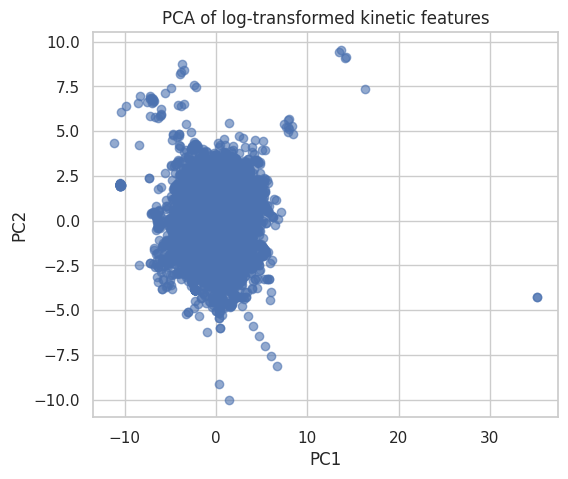

Explained variance ratio: [0.6053519 0.3946481]


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = ['log_kcat_value', 'log_km_value', 'log_kcat_over_km']
X = enzy_data_pro[features].dropna()
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(pcs[:,0], pcs[:,1], alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of log-transformed kinetic features')
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


分酶种（enzyme）或分底物（substrate）分析

In [27]:
enzy_data_pro.groupby("enzyme")[features].corr(method='pearson')

log_kcat_value  log_km_value  \
enzyme                                                                     
(+)-germacrene D synthase log_kcat_value               NaN           NaN   
                          log_km_value                 NaN           NaN   
                          log_kcat_over_km             NaN           NaN   
(+)-limonene synthase     log_kcat_value          1.000000     -0.871420   
                          log_km_value           -0.871420      1.000000   
...                                                    ...           ...   
∆RhLacc                   log_km_value           -0.593256      1.000000   
                          log_kcat_over_km        0.958703     -0.797709   
∆TM-FAAH                  log_kcat_value               NaN           NaN   
                          log_km_value                 NaN           NaN   
                          log_kcat_over_km             NaN           NaN   

                                            log_kcat_over_km  
enzyme                                                        
(+)-germacrene D synthase log_kcat_value                 NaN  
                          log_km_value                   NaN  
                          log_kcat_over_km               NaN  
(+)-limonene synthase     log_kcat_value            0.964775  
                          log_km_value             -0.969773  
...                                                      ...  
∆RhLacc                   log_km_value             -0.797709  
                          log_kcat_over_km          1.000000  
∆TM-FAAH                  log_kcat_value                 NaN  
                          log_km_value                   NaN  
                          log_kcat_over_km               NaN  

[41232 rows x 3 columns]

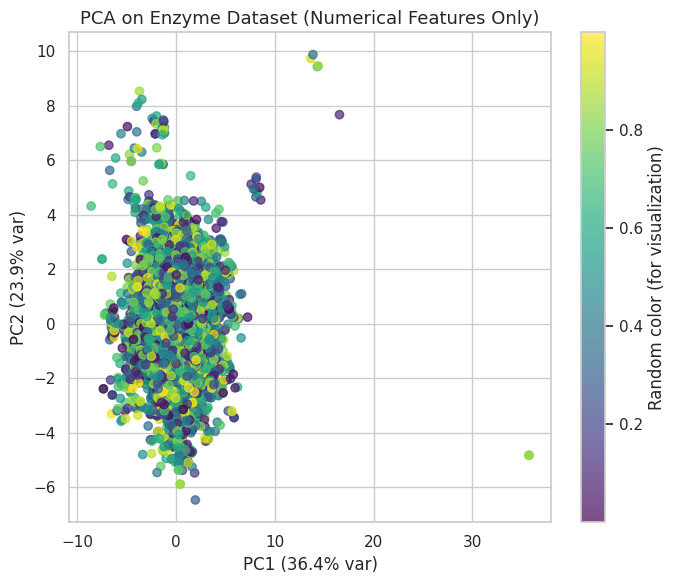

Explained variance ratio per component:
  PC1: 0.364
  PC2: 0.239


In [28]:

from sklearn.decomposition import PCA
# 用于 PCA 的数值列

numeric_cols = [
    'log_kcat_value', 'log_km_value', 'log_kcat_over_km',
    'temperature_C', 'pH_value'
]

# 仅保留存在于 df 中的列
numeric_cols = [c for c in numeric_cols if c in enzy_data_pro.columns]

# 去除缺失值
df_pca = enzy_data_pro[numeric_cols].dropna().copy()

# -----------------------
# 标准化
# -----------------------
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca)

# -----------------------
# PCA 分析
# -----------------------
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# -----------------------
# 可视化
# -----------------------
plt.figure(figsize=(7,6))
plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    c=np.random.rand(len(df_pca)),
    cmap='viridis',
    alpha=0.7
)

plt.title('PCA on Enzyme Dataset (Numerical Features Only)', fontsize=13)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.colorbar(label="Random color (for visualization)")
plt.tight_layout()
plt.show()

print("Explained variance ratio per component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.3f}")


## 2.1.6 SMILEs Processing ##


In [33]:
def smiles_to_mol(smiles_str):
    """Convert SMILES string to RDKit Mol object; returns None if invalid."""
    try:
        mol = Chem.MolFromSmiles(smiles_str, sanitize=True)
        return mol
    except Exception:
        return None

FP_SIZE = 2048
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=FP_SIZE)
RDLogger.DisableLog('rdApp.*') # ignore invalid smiles when processing

def mol_to_morgan_fingerprint(mol, generator=morgan_gen, fp_size=FP_SIZE):
    """Generate Morgan fingerprint using modern RDKit API."""
    if mol is None:
        return np.zeros(fp_size, dtype=int)
    fp = generator.GetFingerprint(mol)
    arr = np.zeros((fp_size,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


def mol_to_basic_descriptors(mol):
    """Compute a few common molecular descriptors."""
    if mol is None:
        return pd.Series({
            "MolWt": np.nan,
            "LogP": np.nan,
            "NumHDonors": np.nan,
            "NumHAcceptors": np.nan
        })
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol)
    })


enzy_data_pro["mol"] = enzy_data_pro["smiles"].apply(smiles_to_mol)

# Create descriptor columns
desc_df = enzy_data_pro["mol"].apply(mol_to_basic_descriptors)
desc_df.columns = [f"desc_{c}" for c in desc_df.columns]

# Create fingerprint matrix
fingerprints = np.vstack(enzy_data_pro["mol"].apply(lambda m: mol_to_morgan_fingerprint(m)))

# Combine into one dataframe
fingerprint_df = pd.DataFrame(fingerprints, columns=[f"fp_{i}" for i in range(fingerprints.shape[1])])
enzy_data_pro_2 = pd.concat([enzy_data.reset_index(drop=True), desc_df.reset_index(drop=True), fingerprint_df], axis=1)

print("✅ SMILES processing complete.")
print(enzy_data_pro_2.head())


✅ SMILES processing complete.
    enzyme                                        enzyme_full substrate  \
0  GPI-PLC  glycosylphosphatidylinositol-specific phosphol...       VSG   
1  GPI-PLC  glycosylphosphatidylinositol-specific phosphol...       VSG   
2  GPI-PLC  glycosylphosphatidylinositol-specific phosphol...       VSG   
3  GPI-PLC  glycosylphosphatidylinositol-specific phosphol...       VSG   
4   xSMUG1  single-strand-selective monofunctional uracil-...       ssU   

             organism               kcat_km temperature    pH  \
0  Trypanosoma brucei                  None        None  None   
1  Trypanosoma brucei                  None        None  None   
2  Trypanosoma brucei                  None        None  None   
3  Trypanosoma brucei                  None        None  None   
4                None  2.3 × 10^6 s^-1 M^-1        None  None   

            descriptor      pmid canonical         cid brenda_id  \
0     Acylated GPI-PLC  10026218  10026218  [71305032]      